## NARX SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

from tensorflow import keras

# Creando Coenxión con Mongo DB

In [2]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['polygons', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [3]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head(10)

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022
2022-01-01,62e6d1d870bebdf1983a27a4,2022,1,25.60,26.55,-0.95,enero,738156,738367,2022-01-01,January-2022
2021-12-01,62e6d1d870bebdf1983a27a3,2021,12,25.54,26.60,-1.06,diciembre,738125,738367,2021-12-01,December-2021
2021-11-01,62e6d1d870bebdf1983a27a2,2021,11,25.76,26.70,-0.94,noviembre,738095,738367,2021-11-01,November-2021
2021-10-01,62e6d1d870bebdf1983a27a1,2021,10,25.78,26.72,-0.94,octubre,738064,738367,2021-10-01,October-2021


In [4]:
# Registros
print(data_pandas.shape)
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

(870, 11)
1950-01-01 00:00:00
2022-06-01 00:00:00


Aplicando transformación

In [5]:
data_pandas.head()

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022


In [6]:
class minimax:

    @classmethod
    def create(cls, value):

        clase = cls()

        clase.log_values = np.log(value)
        clase.max = clase.log_values.max()
        clase.min = clase.log_values.min()

        return clase

    def transformacion(self):

        return (self.log_values - self.min)/(self.max - self.min)

    def inversa(self,y):

        return  ( y*(self.max - self.min) ) + self.min

In [7]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()

# Transformacion
transformacion = minimax.create( data_model.nino34_mean.to_numpy() )



data_model['sst'] = transformacion.transformacion()
data_model['sst_exogena'] = transformacion.transformacion()

data_model.head()

,nino34_mean,sst,sst_exogena
periodo,,,
2022-06-01,26.96,0.549133,0.549133
2022-05-01,26.82,0.522145,0.522145
2022-04-01,26.71,0.500842,0.500842
2022-03-01,26.32,0.424597,0.424597
2022-02-01,25.87,0.335206,0.335206


Definiendo datos

In [8]:
y_output = 'sst'
exogena = ['sst_exogena']


pd_model = data_model[ [y_output] + exogena].sort_index(ascending=True)
pd_model.head(10)

,sst,sst_exogena
periodo,,
1950-01-01,0.065844,0.065844
1950-02-01,0.172380,0.172380
1950-03-01,0.337210,0.337210
1950-04-01,0.418685,0.418685
1950-05-01,0.398931,0.398931
1950-06-01,0.454055,0.454055
1950-07-01,0.416713,0.416713
1950-08-01,0.337210,0.337210
1950-09-01,0.307078,0.307078


Definiendo clase NARX

In [9]:
from NINO34 import *

prediction_order = 12 # rango de prediccion
auto_order = 12 # componente autoregresiva
exog_order = 36 # componente exogena qm
exog_delay = 0 # componente exogena dm


training_model = KERAS_NARX_NINO34(pd_model = pd_model,
                                    y_output = y_output,
                                    exogena = exogena,
                                    prediction_order = prediction_order,
                                    auto_order = auto_order,
                                    exog_order = exog_order,
                                    exog_delay = exog_delay)

# Generando datos para entrenamiento 
training_model.split_data()

2022-08-12 23:40:53.691871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 dense (Dense)               (None, 96)                4704      
                                                                 
 dense_1 (Dense)             (None, 48)                4656      
                                                                 
 dense_2 (Dense)             (None, 1)                 49        
                                                                 
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


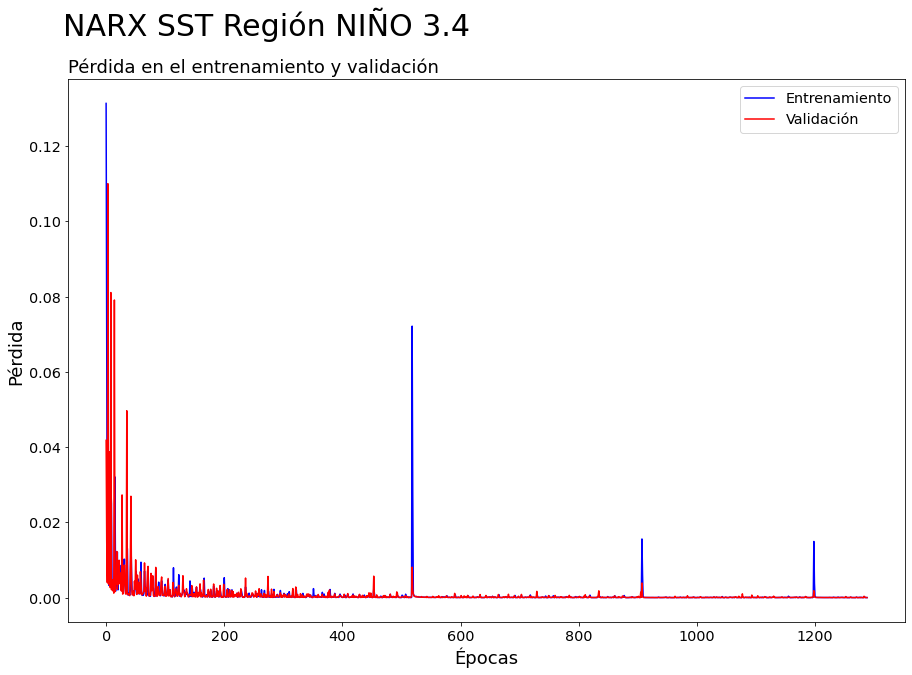

In [10]:
training_model.training_model(layers=[training_model.ninp,2*training_model.ninp,training_model.ninp],
                            activation = "selu",
                            kernel_initializer = "lecun_normal",
                            learning_rate = 1e-3,
                            loss = "mean_squared_error",
                            epochs = 5000,
                            batch_size = 32,
                            validation_split = 0.20,
                            path_checkpoint = "./model_checkpoint/narx_sst_nino34.h5",
                            patience = 100,
                            min_delta = 0,
                            monitor = 'val_loss',
                            mode = 'min')

training_model.model.summary()

training_model.loss_plot(title='NARX SST Región NIÑO 3.4',
                        path='./figure/nino34/loss_narx_model_nino34.png')

Validando resultados

<AxesSubplot:>

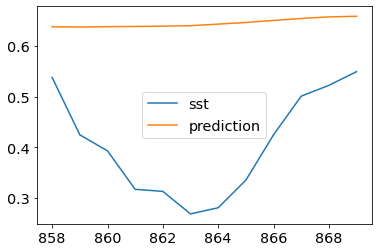

In [13]:
training_model.validation_test(batch_size=32)

training_model.pd_validation[training_model.pd_validation.type=='validation'][[y_output,'prediction']].plot()

In [12]:
pd_summary = training_model.pd_validation.copy()
pd_summary['nino34_mean'] = (data_std[data_std.index=='nino34_mean'][0]*pd_summary.t_nino34_mean) + data_mean[data_mean.index=='nino34_mean'][0]
pd_summary['prediction_nino34_mean'] = (data_std[data_std.index=='nino34_mean'][0]*pd_summary.prediction) + data_mean[data_mean.index=='nino34_mean'][0]


pd_summary

NameError: name 'data_std' is not defined